# Código para calcular difusión, mediante el Método de Volumenes Finitos
## -Creación de malla triangular automática.
## -Requiere programar la ecuación deseada.

In [4]:
import numpy as np
import openmesh as om
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns  #graficar datos de pandas
from pylab import savefig

import sys
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt



##  Crear la malla:


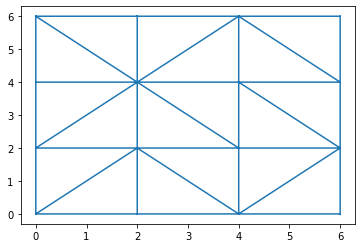

Malla automática


In [5]:
def save_mesh(P, T, filename):
    mesh = om.TriMesh()
    
    filename2 = filename[0:-4]+'_2.off'
    
    print('Malla automática')
    sys.stdout = open(filename2, 'w')
    
    print(len(P), len(T.simplices), 0)
    
    k=0
    vh=[]
    #Generar vertices
    for p in P:
        k=k+1; 
        print('%.2f' % p[0] ,'%.2f' % p[1], 0)    
        vh.append(mesh.add_vertex([p[0], p[1], 0]))
    
    k=0
    #Generar celdas
    for t in T.simplices:
        k=k+1
        print(3,' ',t[0], t[1], t[2])
        mesh.add_face(vh[t[0]],vh[t[1]],vh[t[2]])

    om.write_mesh(filename, mesh)
    

#Parámetros de la malla    
X = np.arange(0,7,2)
Y = np.arange(0,7,2)


P = np.array([[x,y] for y in Y for x in X])
T = Delaunay(P)
plt.triplot(P[:,0],P[:,1],T.simplices)


save_mesh(P, T, 'MallaAuto.off')

mesh = om.read_trimesh('MallaAuto.off')

plt.show()


## Datos relevantes:
### - Indice
### - Celdas vecinas
### - Lados correspondientes

In [ ]:
#Vertices correspondientes a cada celda
for vh in mesh.vertices():    
    v = mesh.point(vh)
    #print(v)

#Número de interfaces (lados)
Int = 0
for eh in mesh.edges(): #eh = interfaces
    Int = Int + 1  

#print('La cantidad de interfaces es:',Int)

#Información por cada celda
for fh in mesh.faces():  
    index = fh.idx() 
    #print("Cara: ",index)
    
    #Recorrer los vertices de cada cara y mostrar sus indices
    for vh in mesh.fv(fh):
        indx = vh.idx() 
        #print(indx)
    #Mostrar las celdas vecinas    
    for fh in mesh.ff(fh):
        VCel = fh.idx() 
        #print(VCel)
    #mostrar los lados correspondientes a cada celda    
    for eh in mesh.fe(fh):
        Lad = eh.idx()
        #print('Lados',Lad)

        
print('El numero de caras es: ', index +1) 

## Generar arreglos vacíos para utilizarlos posteriormente

In [ ]:
#longitud de los lados
Longitud = np.zeros(Int)

#Áreas de las celdas
Area = []

#Centros de cada lado (Coordenada horizontal y vertical)
Centrox  = np.zeros(Int)
Centroy  = np.zeros(Int)

#Baricentros de las celdas (Coordenada horizontal y vertical) 
BariX = []
BariY = []

#Normales (Coordenada horizontal y vertical) 
NormalX = []
NormalY = []

#Distancia centro de las celda a centro de los lados
DCenLad = []

#Distancia nodos a centro de las celdas
DNodoCel = np.zeros((index-1,index+1))

#Relacion celda y sus bordes
CelBord = np.zeros((index +1,3))

#Relacion celda a celdas vecinas
CelCels = np.zeros((index +1,3))

#Relacion celda vertices
CelVer = np.zeros((index +1,3))

#Sumatoria de los inversos de las distancias nodo - centro (parte del método de volumenes finitos)
Suminv = []

## Cálculos de:
- Longitud
- Área
- Distancia

In [ ]:
#fh para Recorrer todas las celdas
for fh in mesh.faces():
    VCel = fh.idx()

    #Arreglos para guardas las coordenas x,y de los vertices
    VeX = [] 
    VeY = [] 
    
    #dentro de cada celda recorrer los vertices
    for vh in mesh.fv(fh):
        P = mesh.point(vh)
        XX = P[0] 
        YY = P[1]
        VeX.append(XX)
        VeY.append(YY)       

       
    #baricentro de cada celda
    baX = sum(VeX)/3
    baY = sum(VeY)/3
    
    #Guardar baricentros en el arreglo
    BariX.append(baX)
    BariY.append(baY)

    #área de las celdas
    Area_i = VeX[0] * (VeY[2] - VeY[1]) + VeX[1] * (VeY[0] - VeY[2]) + VeX[2] * (VeY[1] - VeY[0])
    Area_i = 0.5 * np.absolute(Area_i)
    
    #guardar áreas en el arreglo
    Area.append(Area_i)

    #Arreglo para el cálculo distancia centro celda - centro lado
    DistCelLad = []

    #contador auxiliar (lados)
    Cont = 0

    #arreglo para guardar normales
    xNormal = []
    yNormal = []

    #dentro de cada celda recorrer los lados
    for eh in mesh.fe(fh):
        #calcular longitud de los lados
        Lad = eh.idx()
        LX = VeX[Cont -1] - VeX[Cont]
        LY = VeY[Cont -1] - VeY[Cont]

        #punto medio de cada lado (coordenada x e y)
        MedX = (VeX[Cont - 1] + VeX[Cont])*0.5
        MedY = (VeY[Cont - 1] + VeY[Cont])*0.5
        
        #arreglo para guardar los puntos medios
        Centrox[Lad] = MedX
        Centroy[Lad] = MedY
        
        #longitud de los segmentos (fórmula de distancia)
        distancia = np.sqrt(pow(LX,2) + pow(LY,2))
        Longitud[Lad] = distancia 

        #distancia baricentro a centro de los segmento (lados)
        dbsX = BariX[VCel] - MedX
        dbsY = BariY[VCel] - MedY
        distanciaBS = np.sqrt(pow(dbsX,2) + pow(dbsY,2))

        DistCelLad.append(distanciaBS)

        #tangente unitaria
        tx = -LX / distancia
        ty = -LY / distancia
        
        # normal unitaria
        xNormal.append(ty)
        yNormal.append(-tx)
        
        Cont = Cont + 1
    

    #agregar al arreglo las 3 normales de cada celda
    NormalX.append(xNormal)
    NormalY.append(yNormal)

    #agregar al arreglo la distancia de centro a centro
    DCenLad.append(DistCelLad)

#obtenemos los maximos y los minimos de los centros de los bordes, util para determinar si se trata de un borde frontera
MinX = np.amin(Centrox)
MinY = np.amin(Centroy)
MaxX = np.amax(Centrox)
MaxY = np.amax(Centroy)

## Agregar vector tiempo

In [ ]:
# tamaño del vector de tiempo
Tiemp = 25

# Arreglo de tiempo
Time = np.linspace(0,Tiemp,1)

dt = 1 / Tiemp

## Información de conectividad
### Información sobre lados-frontera

In [ ]:
#arreglo para los lados
InLad = np.zeros(Int)

for eh in mesh.edges(): 
    Lad = eh.idx()
    InLad[Lad] = Lad
    
    
# auxiliar que guarda si un lado corresponde a una frontera del dominio
AuxLad = np.zeros(Int)

#Recorrer las celdas 
for fh in mesh.faces():
    VCel = fh.idx()
    #auciliar para las celdas
    ACel = []
    #auxiliar para fronteras
    Fronter = []
    
    
    index = 0
    
    #recorrer los bordes para verificar si corresponden a fronteras
    for eh in mesh.fe(fh): 
        Lad = eh.idx()
        valueX = Centrox[Lad]
        valueY = Centroy[Lad]
        CelBord[VCel, index] = Lad

        if valueX == MaxX or valueX == MinX or valueY == MaxY or valueY == MinY:
            #evaluo la condicion de frontera
            Fronter.append(1)
            AuxLad[Lad] = 1
        else:
            Fronter.append(0)
            AuxLad[Lad] = 0
        index = index + 1
        
    #Ver relacion entre una celda y sus bordes   
    #print(VCel, Fronter)  
    

    for fh in mesh.ff(fh):
        VCel_v = fh.idx()
        ACel.append(VCel_v)
    
    #Arreglo de celdas y sus vecinos
    index = 0
    
    #recorrer el auxiliar
    Audx = 0 
    for value in Fronter:  
        if value == 1:
            aux = int(-1)
            CelCels[VCel, index] = aux
        else:
            CelCels[VCel, index] = ACel[Audx]
            Audx = Audx + 1
        index = index + 1
    
    # OBTENEMOS LA MATRIZ DE LINK DE LA CELDA CON SUS VERTICES
    index = 0
    for vh in mesh.fv(fh):
        Celve = vh.idx()
        CelVer[VCel,index] = Celve
        index = index + 1
      

    
#lados frontera
#print(AuxLad) 

## Ingresar condiciones iniciales: 


In [ ]:
#contentracion inicial por cada celda
Ui = []

#evolucion en el tiempo
HT = []
HT.append(Ui)

#concentracion en el borde (debe ser constante)
UF = 0

#Difusión
Difu = 1

## Ecuación 
### ( Programar ecuación de difusión)

## Gráfica

In [ ]:
plt.plot()
plt.show()

## Mapa de calor

In [ ]:
plt.figure(figsize =(30,15))
mapa = sns.heatmap(0,cmap='coolwarm') #en el lugar de 0 agregar la variable de difusión
figure = mapa.get_figure()
figure.savefig('mapa_calor.png',dpi=400)
plt.xlabel('Celdas')
plt.ylabel('Tiempo')
plt.show()